In [1]:
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2
from keras.optimizers import SGD,Adagrad

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import dicom

In [4]:
K.set_session(sess)

# Segmentation of ROI
- TODO: code for data_generator? or directly batch? Holds in memmory? 

In [5]:
model = Sequential()
model.add(Convolution2D(100, 11, 11, border_mode='same', input_shape=(1, 64, 64),init='glorot_normal'))
model.add(MaxPooling2D(pool_size=(6, 6)))
model.add(Flatten())
model.add(Dense(1024,activation='sigmoid'))

In [6]:
sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 100, 64, 64)   12200       convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 100, 10, 10)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 10000)         0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          10241024    flatten_1[0][0]                  
Total params: 10253224
____________________________________________________________________

# Filters Pre-training -  Sparse autoencoder

In [7]:
from keras import backend as K
from keras.regularizers import Regularizer
from keras.objectives import kld
import h5py

In [8]:
# For the Kullback-Leibler divergence regularization

class SparseActivityRegularizer(Regularizer):

    def __init__(self, l1=0., l2=0.,p = 0.05,beta = 3):
        self.l1 = K.cast_to_floatx(l1)
        self.l2 = K.cast_to_floatx(l2)
        self.uses_learning_phase = True
        self.layer = None
        self.p = p

    def set_layer(self, layer):
        if self.layer is not None:
            raise Exception('Regularizers cannot be reused')
        self.layer = layer

    def __call__(self, loss):
        if self.layer is None:
            raise Exception('Need to call `set_layer` on '
                            'ActivityRegularizer instance '
                            'before calling the instance.')
        regularized_loss = loss
        
        
        for i in range(len(self.layer.inbound_nodes)):
            output = self.layer.get_output_at(i)
            
            p_hat = K.mean(output, axis=0)
            regularized_loss += beta*K.sum(self.p * K.log(self.p / (p_hat+K.epsilon())))
            
        return K.in_train_phase(regularized_loss, loss)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'l1': float(self.l1),
                'l2': float(self.l2)}


#### First we need to generate the dataset of 11*11 patches from the images to pre-train the filters of the convolutional network

In [28]:
file_h5 = h5py.File(PATH_TRAINING,'r')
n = file_h5['X'].shape[0]

In [34]:
# Random sequences for random patches
seq = np.random.randint(n,size = (int(N1)))
i_idx = np.random.randint(64-11,size = (int(N1)))
j_idx = np.random.randint(64-11,size = (int(N1)))

In [54]:
def generate_patch_from_h5(path,seq,i_seq,j_seq,patch_size = 11,N1 = int(1e4)):
    '''
    Generates patches of size 11*11 to feed to the sparse auto-encoder
    '''
    
    while 1:
        file_h5 = h5py.File(path,'r')
        n = file_h5['X'].shape[0]

        for k in range(int(N1)):

            img = file_h5['X'][seq[k]]
            i = i_seq[k]
            j = j_seq[k]

            patch = img[i:i+11,j:j+11]
            patch = patch.flatten().reshape(1,121)

            yield (patch,patch)

        file_h5.close()
    

In [88]:
PATH_TRAINING = '../data/input_training.h5'
nb_epoch = 50
N1 = int(1e4)

In [89]:
lambd = 1e-4
rho = 0.1
beta = 3

activity_regularizer = SparseActivityRegularizer(p=rho,beta=beta)

autoencoder = Sequential()
# Hidden layer, the bias is included by default
autoencoder.add(Dense(100,input_dim=121,activation='sigmoid',W_regularizer=l2(lambd/2),activity_regularizer=activity_regularizer))
autoencoder.add(Dense(121,activation='sigmoid',W_regularizer=l2(lambd/2)))
autoencoder.summary()

#sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
ada = Adagrad()
autoencoder.compile(loss='mean_squared_error', optimizer=ada)
                         
history = autoencoder.fit_generator(generate_patch_from_h5(PATH_TRAINING,seq,i_idx,j_idx),samples_per_epoch=N1, nb_epoch=nb_epoch,nb_worker=4)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_18 (Dense)                 (None, 100)           12200       dense_input_9[0][0]              
____________________________________________________________________________________________________
dense_19 (Dense)                 (None, 121)           12221       dense_18[0][0]                   
Total params: 24421
____________________________________________________________________________________________________
Epoch 1/50
10000/10000 [==============================] - 86s - loss: 1783.9489    
Epoch 2/50
10000/10000 [==============================] - 86s - loss: 1783.6146    
Epoch 3/50
10000/10000 [==============================] - 87s - loss: 1783.5650    
Epoch 4/50
10000/10000 [==============================] - 87s - loss: 1783.5348    
Epoch 5/50
10000/10000 [==============

/Users/Thomas/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The "nb_worker" argument is deprecated when pickle_safe is False
  warnings.warn('The "nb_worker" argument is deprecated when pickle_safe is False')


In [104]:
autoencoder.save_weights('../data/weights/filters.h5')

## This allows to plot the filters

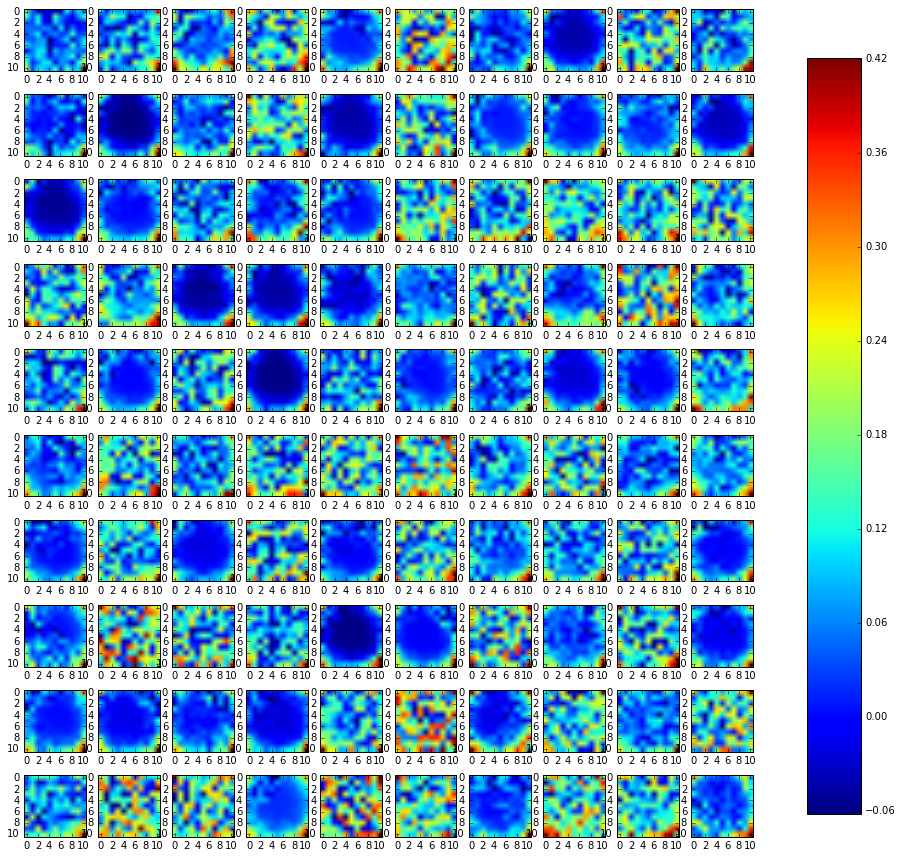

In [101]:

fig, axes = plt.subplots(nrows=10, ncols=10)
for k,ax in enumerate(axes.flat):
    im = ax.imshow(autoencoder.layers[0].get_weights()[0][:,k].reshape(11,11))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()

# This plots the evolution of the loss

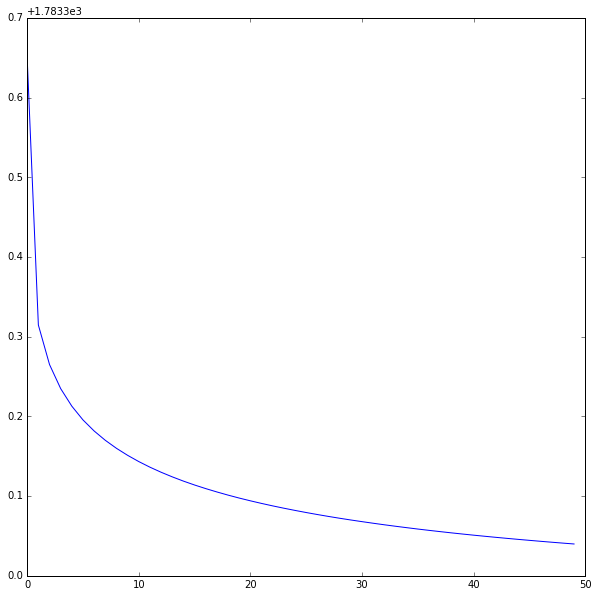

In [103]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])

# Output pre-training

In [ ]:
lamd = 1e-4
# The input will be the MaxPooled activations of size (100,9,9)
pretrain = Sequential()
pretrain.add(Flatten(input_shape = (100,9,9)))
pretrain.add(Dense(1024,activation='sigmoid',W_regularizer=l2(lamd)))
pretrain.summary()

sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
pretrain.compile(loss='mean_squared_error', optimizer=sgd)

In [ ]:
import h5py,os 
OUTPUT = '../data/roi_training.h5'
file_h5 = h5py.File(OUTPUT, "r")
file_h5['X']

PathDicom = "../data/Sunnybrook Cardiac MR Database ContoursPart3"
lstFilesDCM_Training = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".txt" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM_Training.append(os.path.join(dirName,filename))

len(lstFilesDCM_Training)

In [ ]:
mask = file_h5['X'][0]
mask
plt.imshow(mask)

In [ ]:
import scipy
import scipy.ndimage

In [ ]:
mask32 = np.zeros((32,32))
for i in range(32):
    for j in range(32):
        mask32[i][j] = mask[2*i][2*j]

In [ ]:
plt.imshow(mask32)